# Imagen Training Script on CocoCaptions Dataset

CocoCaptions Dataset - [documentation](https://pytorch.org/vision/main/generated/torchvision.datasets.CocoCaptions.html)

To do
- Use wandb for keeping track of training runs
- Do a run with BaseUnet 128 and SRUnet 64
- Sample images and show results once every 5 or so epochs for second unet

In [1]:
import os 
import yaml
import math
import numpy as np
from time import time
from PIL import Image
from pathlib import Path
from flatdict import FlatDict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torchvision
from torch.utils import data
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import datasets, utils
from imagen_pytorch.t5 import t5_encode_text, DEFAULT_T5_NAME
from imagen_pytorch import Unet, Imagen, ImagenTrainer, BaseUnet64, SRUnet256

# from imagen_config import config as cfg
from transformations import ComposeDouble, FunctionWrapperDouble, select_random_label, select_fixed_label

import wandb
import logging
import warnings
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [2]:
# !wandb login

In [3]:
cfg = yaml.safe_load(Path("configs\\imagen-medium-config.yaml").read_text())
cfg_flat = dict(FlatDict(cfg, delimiter='.'))

In [4]:
wandb.login()

wandb: Currently logged in as: camlaedtke. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project="imagen", entity="camlaedtke", config=cfg_flat)#, resume=True)

In [6]:
def get_emb_tensor(targets):
    text_embeds, text_masks = t5_encode_text(targets, name = cfg["model"]["text_encoder_name"])
    text_embeds, text_masks = map(lambda t: t.to(device), (text_embeds, text_masks))
    return text_embeds, text_masks

In [7]:
data_transforms = ComposeDouble([
    FunctionWrapperDouble(T.Resize(cfg["dataset"]["image_size"]), input=True, target=False),
    FunctionWrapperDouble(T.RandomHorizontalFlip(), input=True, target=False),
    FunctionWrapperDouble(T.CenterCrop(cfg["dataset"]["image_size"]), input=True, target=False),
    FunctionWrapperDouble(T.ToTensor(), input=True, target=False),
    FunctionWrapperDouble(select_random_label, input=False, target=True),
])


train_dataset = datasets.CocoCaptions(
    root = cfg["dataset"]["train"]["root"], 
    annFile = cfg["dataset"]["train"]["ann_file"],
    transforms = data_transforms,
)

valid_dataset = datasets.CocoCaptions(
    root = cfg["dataset"]["val"]["root"],
    annFile = cfg["dataset"]["val"]["ann_file"],
    transforms=data_transforms,
)


train_dataloader = DataLoader(
    dataset = train_dataset, 
    batch_size = cfg["train"]["batch_size"], 
    shuffle = True,
    drop_last = True,
    num_workers = 5,
    prefetch_factor = 3,
    pin_memory=True
)

valid_dataloader = DataLoader(
    dataset = valid_dataset, 
    batch_size = cfg["train"]["batch_size"], 
    shuffle = True,
    drop_last = True,
    num_workers = 5,
    prefetch_factor = 3,
    pin_memory=True
)

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [8]:
# start = time()
# idx = 0
# for X_batch, y_batch in train_dataloader:
#     idx += 1
#     if idx == 100:
#         break
# end = time()
# print(f"{end-start:.4} seconds")

In [9]:
X_batch, y_batch = next(iter(train_dataloader))

Time for 100 batches

| time | num_workers | prefetch_factor | 
| --- | --- | --- |
| 32.94 | 2 | 8 |
| 36.72 | 3 | 8 |
| 24.34 | 4 | 8 |
| **23.61** | **5** | **8** |
| 24.36 | 6 | 8 |
| 25.71 | 6 | 8 |
| 27.30 | 8 | 8 |



| time | num_workers | prefetch_factor | 
| --- | --- | --- |
| 24.76 | 5 | 1 |
| 23.62 | 5 | 2 |
| **23.43** | **5** | **3** |
| 23.52 | 5 | 4 |
| 23.62 | 5 | 5 |
| 23.65 | 5 | 6 |




In [10]:
def display_data(display_list, label_list):
    plt.figure(figsize=(16, 12))
    for i in range(len(display_list)):
        j = 1 if (i < 2) else 2
        img = (display_list[i].cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
        plt.subplot(len(display_list)//3, 3, i+1)
        plt.title(label_list[i], fontsize=12)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

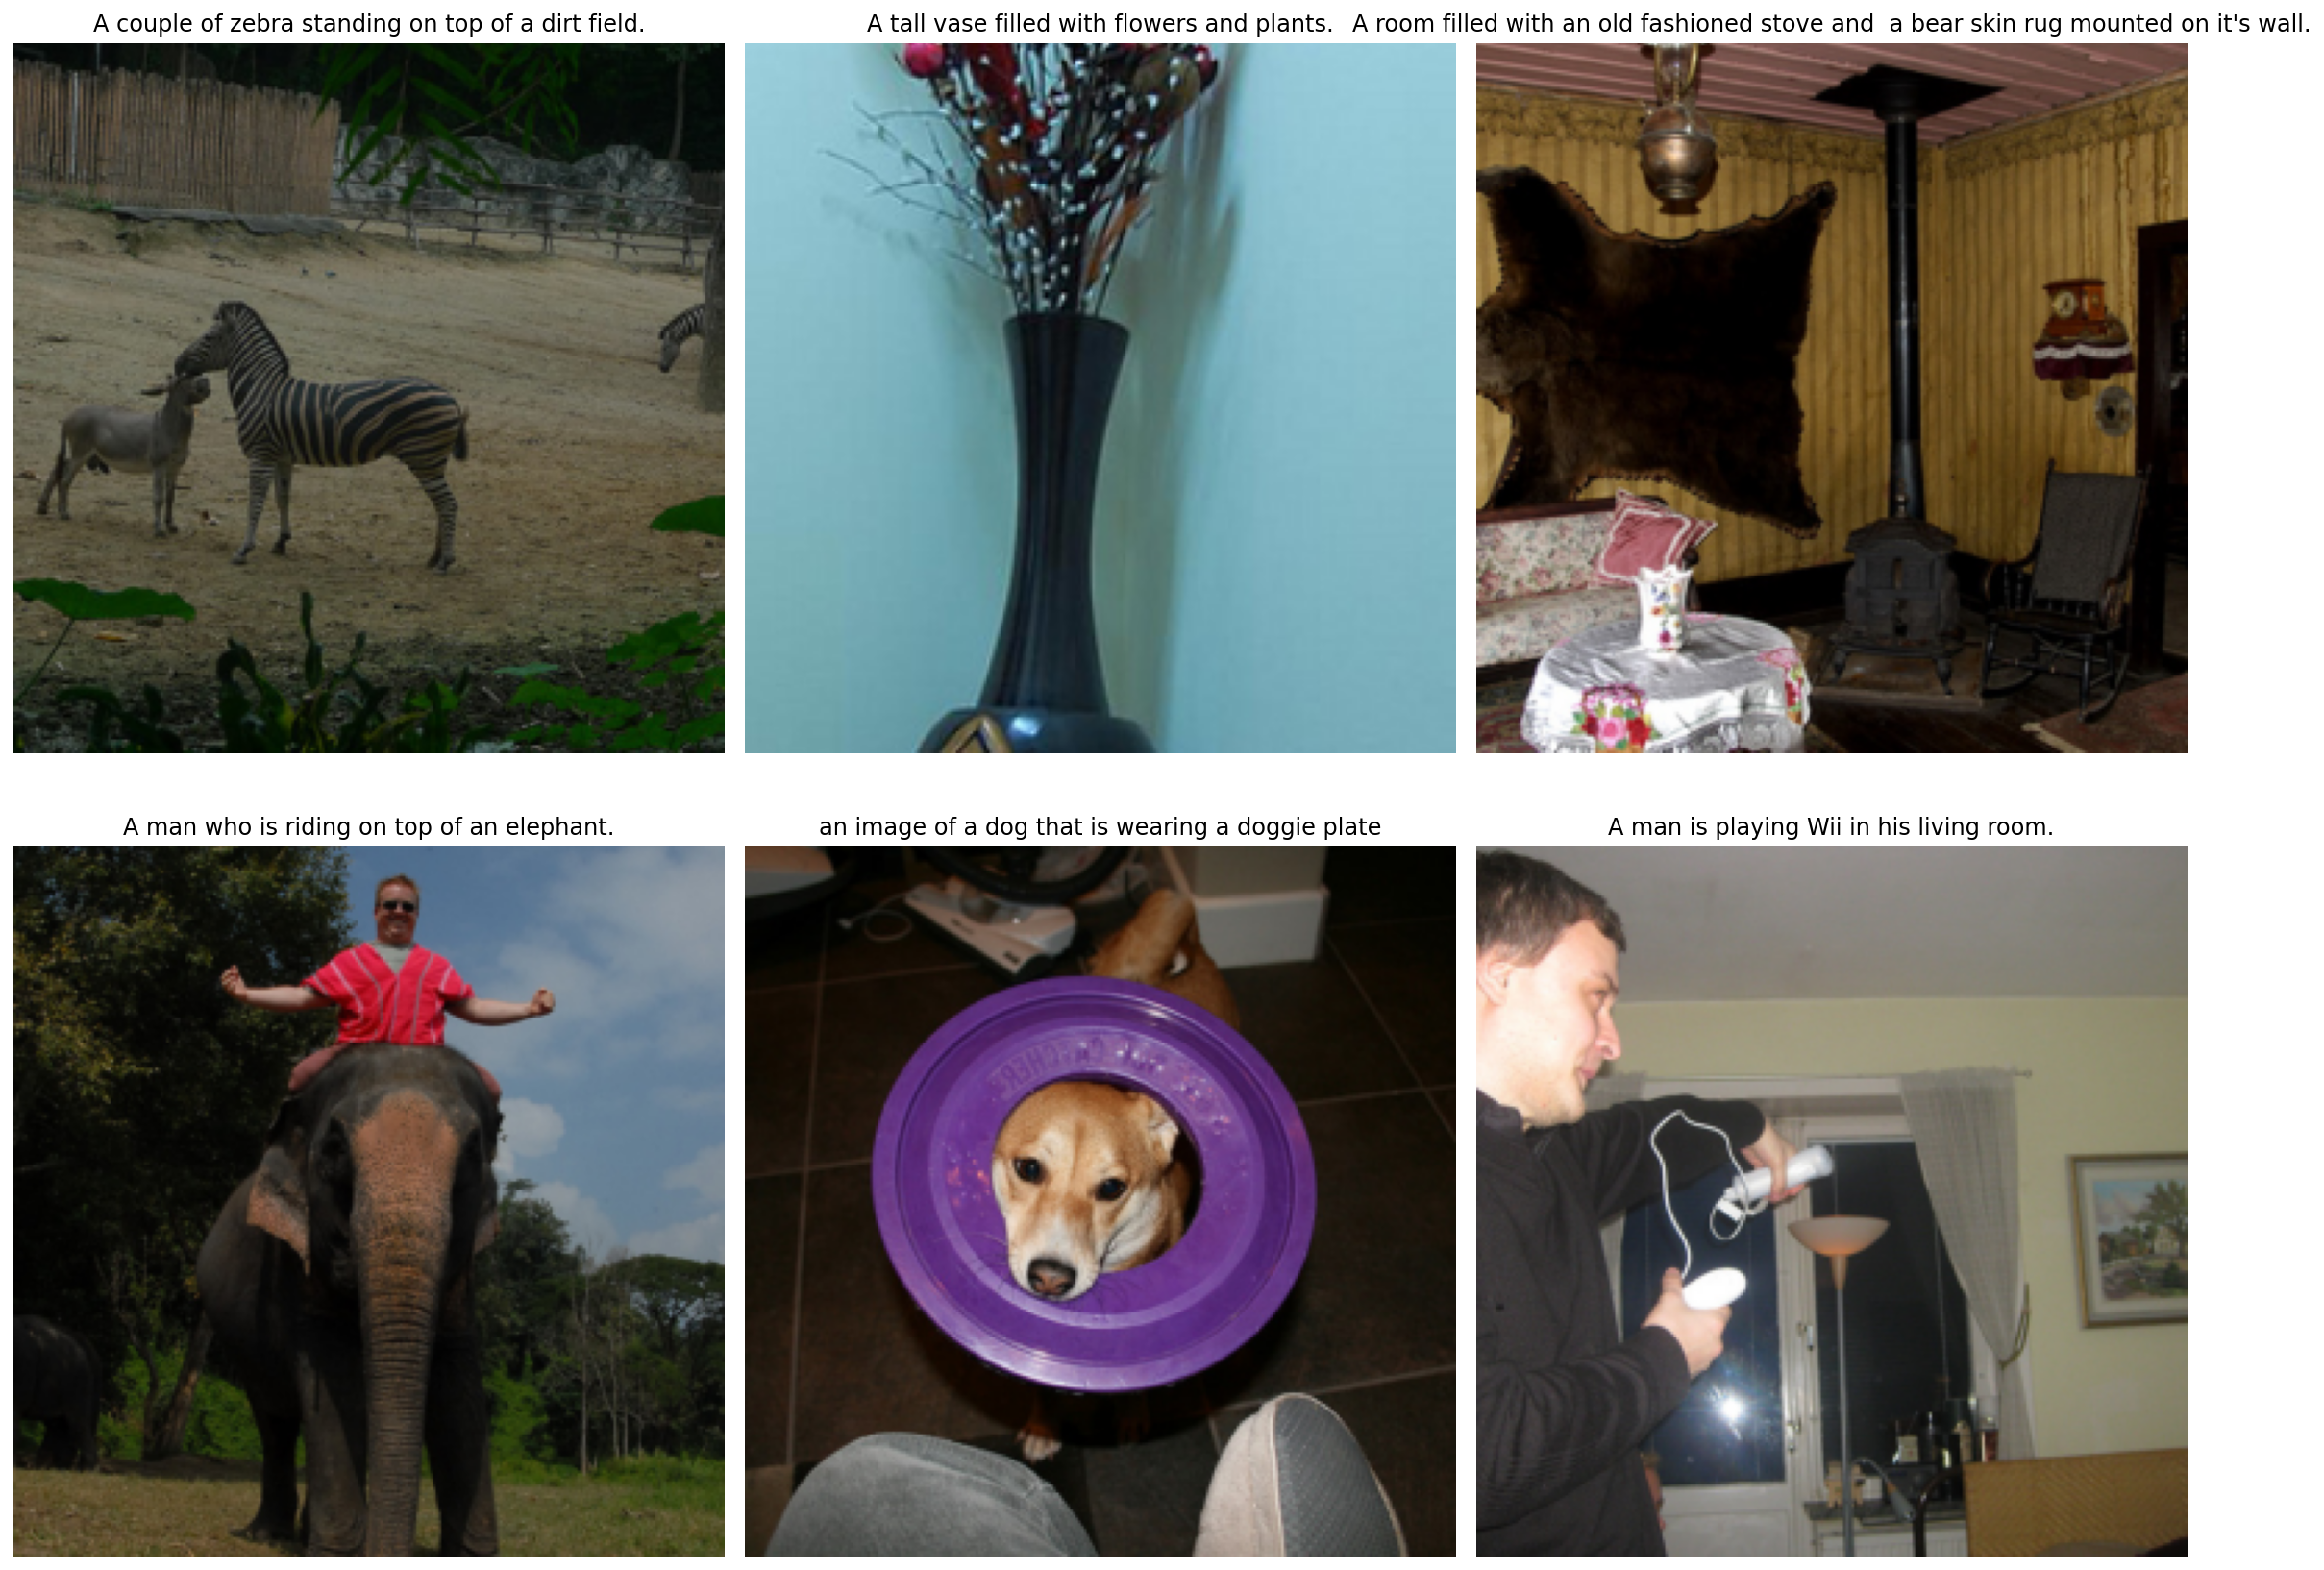

In [11]:
%matplotlib inline
display_data(X_batch[0:6], y_batch[0:6])

In [12]:
BaseUnetConfig = cfg["model"]["base_unet"]
BaseUnet = Unet(
    dim = BaseUnetConfig["dim"],
    dim_mults = BaseUnetConfig['dim_mults'], 
    num_resnet_blocks = BaseUnetConfig["num_resnet_blocks"],
    layer_attns = BaseUnetConfig['layer_attns'], 
    layer_cross_attns = BaseUnetConfig['layer_cross_attns'], 
    attn_heads = BaseUnetConfig["attn_heads"],
    ff_mult = BaseUnetConfig["ff_mult"],
    memory_efficient = BaseUnetConfig["memory_efficient"],
    dropout = BaseUnetConfig["dropout"]
)

SRUnetConfig = cfg["model"]["sr_unet256"]
SRUnet = Unet(
    dim = SRUnetConfig["dim"],
    dim_mults = SRUnetConfig["dim_mults"], 
    num_resnet_blocks = SRUnetConfig["num_resnet_blocks"], 
    layer_attns = SRUnetConfig["layer_attns"],
    layer_cross_attns = SRUnetConfig["layer_cross_attns"], 
    attn_heads = SRUnetConfig["attn_heads"],
    ff_mult = SRUnetConfig["ff_mult"],
    memory_efficient = SRUnetConfig["memory_efficient"],
    dropout = SRUnetConfig["dropout"]
)


imagen = Imagen(
    unets = (BaseUnet, SRUnet),
    text_encoder_name = cfg["model"]["text_encoder_name"], # "t5-large"
    image_sizes = cfg["model"]["image_sizes"], 
    cond_drop_prob = cfg["model"]["cond_drop_prob"],
    timesteps = cfg["model"]["timesteps"],
).cuda()


trainer = ImagenTrainer(
    imagen, 
    amp = cfg["train"]["amp"],
    use_ema = cfg["train"]["use_ema"],
    warmup_steps = eval(cfg["train"]["warmup_steps"]),
    cosine_decay_max_steps = eval(cfg["train"]["cosine_decay_max_steps"]),
)

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [13]:
# try:
#     trainer.load(cfg["train"]["checkpoint_path"], strict=False)
#     print("Loaded checkpoint")
# except: 
#     pass

In [14]:
def display_images(display_list):
    image_list = []
    plt.figure(figsize=(10, 10), dpi=150)
    for i in range(len(display_list)):
        img = display_list[i].cpu().numpy() * 255
        img = np.swapaxes(img,0,2).astype(np.uint8)
        image_list.append(img)
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    return image_list


def save_checkpoint(step, loss, trainer):
    if step % cfg["train"]["checkpoint_rate"] == 0 and step !=0 and not math.isnan(loss): 
        trainer.save(cfg["train"]["checkpoint_path"])
        
        
def print_epoch_stats(e_time, train_loss_arr, valid_loss_arr):
    print(f"   Time: {e_time:.0f} min, "\
          f"Train Loss: {np.mean(train_loss_arr, where=np.isnan(train_loss_arr)==False):.4f}, "\
          f"Valid Loss: {np.mean(valid_loss_arr, where=np.isnan(valid_loss_arr)==False):.4f}")
    
    
def train(train_dataloader, trainer, train_loss_arr, epoch, i):
    fetch_times = []
    embed_times = []
    loss_times = []
    update_times = []
    step_times = []
    for step, batch in enumerate(train_dataloader):
        step_start = time()
        fetch_start = time()
        images, texts = batch
        images = images.to(device)
        fetch_end = time()
        fetch_times.append(fetch_end-fetch_start)
        
        embed_start = time()
        text_embeds, text_masks = get_emb_tensor(texts)
        embed_end = time()
        embed_times.append(embed_end-embed_start)

        loss_start = time()
        loss = trainer(
            images, 
            text_embeds = text_embeds, 
            text_masks = text_masks, 
            unet_number = i, 
            max_batch_size=cfg["train"]["base_unet_max_batch_size"] if i==1 else cfg["train"]["sr_unet256_max_batch_size"]
        )
        loss_end = time()
        loss_times.append(loss_end-loss_start)
        
        update_start = time()
        trainer.update(unet_number = i)
        update_end = time()
        update_times.append(update_end-update_start)
        
        step_end = time()
        step_times.append(step_end-step_start)
        
        train_loss_arr.append(loss)
        save_checkpoint(step, loss, trainer)
        
        curr_step = int(len(train_dataloader)*(epoch-1) + step)
        wandb.log({f"Train Loss {i}": loss, f"Train {i} Step": curr_step})
        print(f"\r   Train Step {step+1}/{len(train_dataloader)}, Train Loss: {loss:.4f}", end='')
        
    
    step_time = np.mean(step_times)
    fetch_time = np.mean(fetch_times)
    embed_time = np.mean(embed_times)
    loss_time = np.mean(loss_times)
    update_time = np.mean(update_times)
    print()
    print(f"      Step: {step_time:.4f}s, Img load: {fetch_time:.4f}s, Embed: {embed_time:.4f}s, "\
          f"Loss: {loss_time:.4f}s, Update: {update_time:.4f}s")
    return trainer, train_loss_arr


def validate(valid_dataloader, trainer, valid_loss_arr, epoch, i):
    for step, batch in enumerate(valid_dataloader):
        images, texts = batch
        images = images.to(device)
        text_embeds, text_masks = get_emb_tensor(texts)

        loss = trainer(
            images, 
            text_embeds = text_embeds, 
            text_masks = text_masks, 
            unet_number = i, 
            max_batch_size=cfg["train"]["base_unet_max_batch_size"] if i==1 else cfg["train"]["sr_unet256_max_batch_size"]
        )
        valid_loss_arr.append(loss)
        
        curr_step = int(len(valid_dataloader)*(epoch-1) + step)
        wandb.log({f"Validation Loss {i}": loss, f"Valid {i} Step": curr_step})
        print(f"\r   Valid Step {step+1}/{len(valid_dataloader)}, Valid Loss: {loss:.4f}", end='')
    print()
    return valid_loss_arr



def run_train_loop(trainer):
    
    for epoch in range(1, cfg["train"]["epochs"]+1):
        print(f"\nEpoch {epoch}/{cfg['train']['epochs']}")
        
        for i in (1,2):
            
            print(f"--- Unet {i} ---")
            start = time()

            train_loss_arr = []; valid_loss_arr = []

            trainer, train_loss_arr = train(train_dataloader, trainer, train_loss_arr, epoch, i)

            valid_loss_arr = validate(valid_dataloader, trainer, valid_loss_arr, epoch, i)

            end = time()
            e_time = (end-start)/60 

            print_epoch_stats(e_time, train_loss_arr, valid_loss_arr)
            if not math.isnan(valid_loss_arr[-1]): 
                trainer.save(cfg["train"]["checkpoint_path"])
            
        texts = [
            'red flowers in a white vase',
            'a puppy looking anxiously at a giant donut on the table',
            'the milky way galaxy in the style of monet'
        ]
        sampled_images = trainer.sample(texts, cond_scale = cfg["train"]["cond_scale"])
        clear_output()
        image_list = display_images(sampled_images)
        images_pil = [Image.fromarray(image) for image in image_list]
        wandb.log({"Samples": [wandb.Image(image) for image in images_pil]})

In [15]:
torch.backends.cudnn.benchmark = True

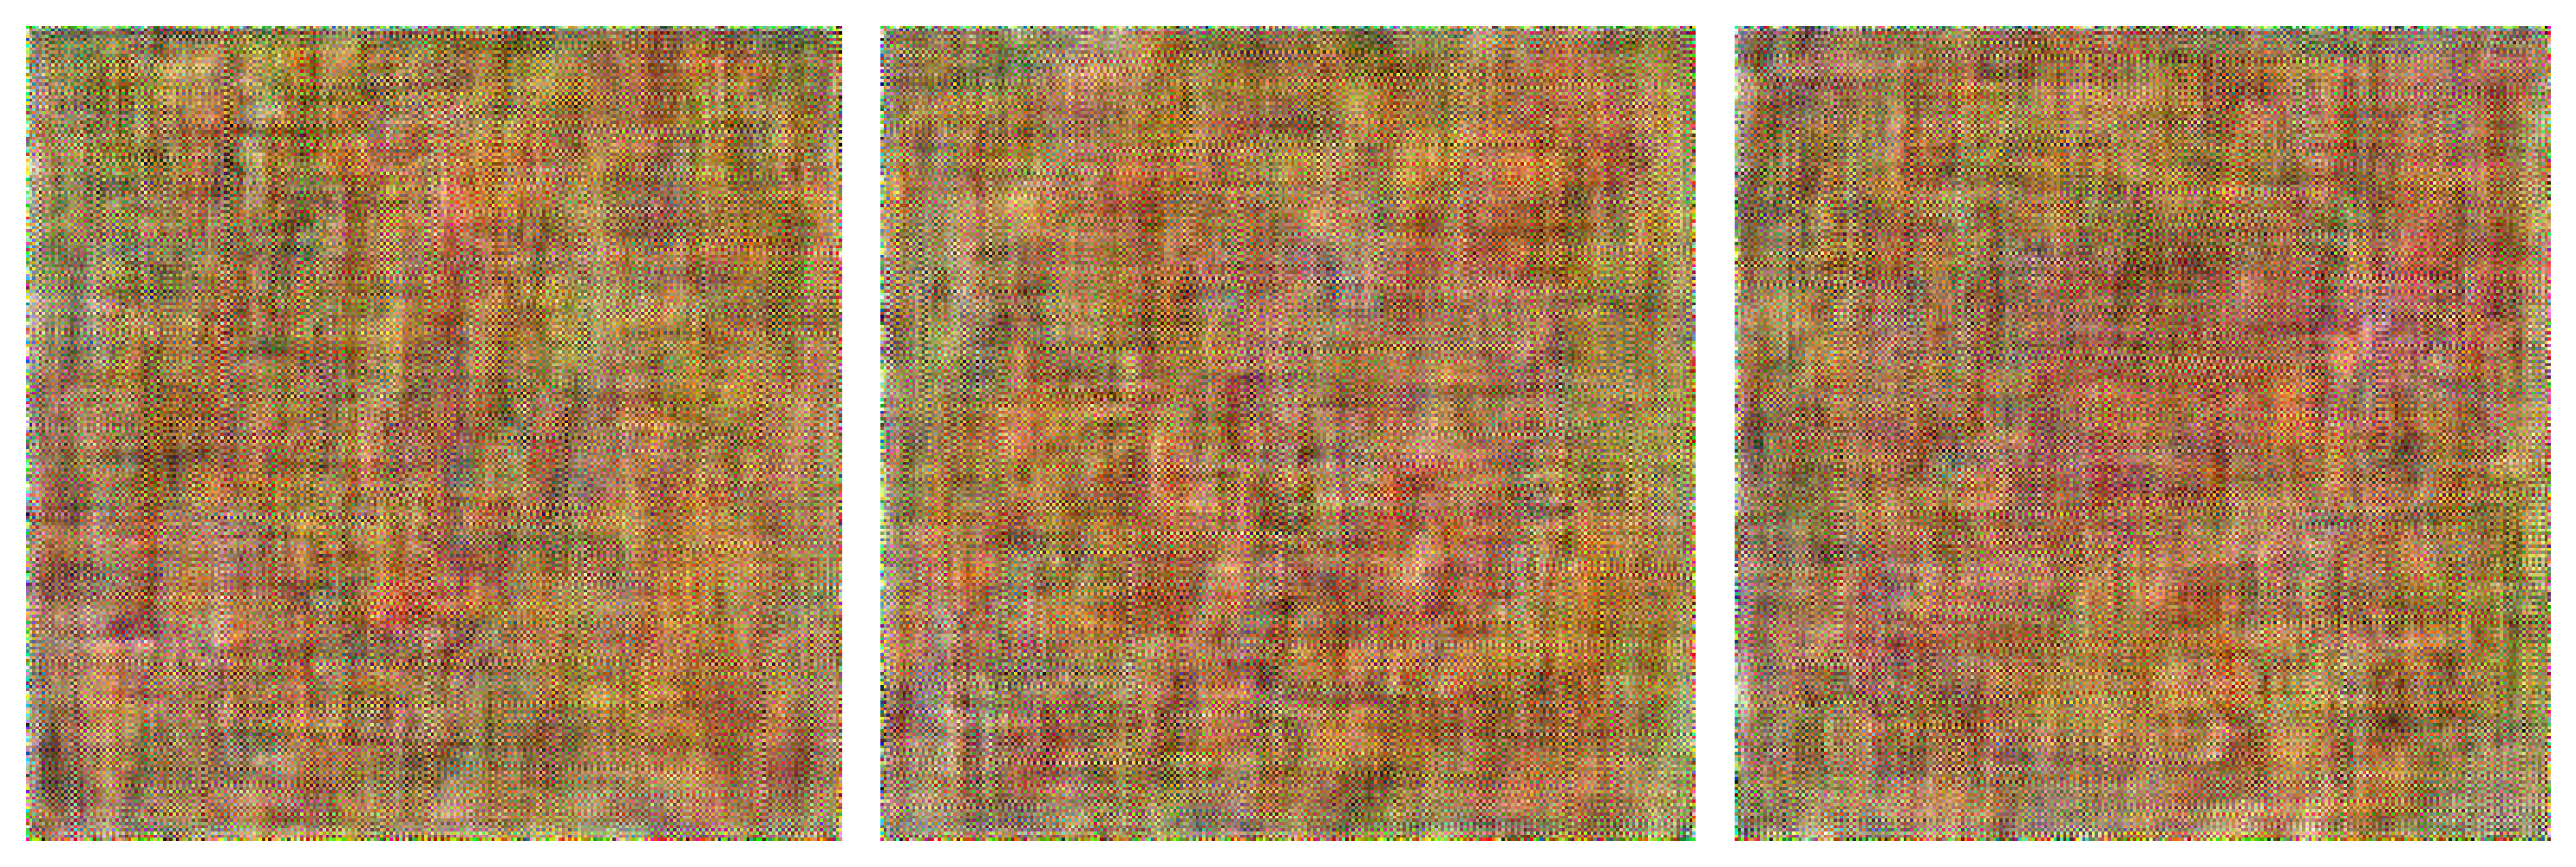


Epoch 2/25
--- Unet 1 ---
   Train Step 481/1293, Train Loss: 0.0203

In [ ]:
run_train_loop(trainer)

In [ ]:
try:
    trainer.load(cfg["train"]["checkpoint_path"])
    print("Loaded checkpoint")
except: 
    pass

In [ ]:
texts = [
    'red flowers on a beach by the sunset',
    'a puppy looking anxiously at a giant donut on the table',
    'the milky way galaxy in the style of monet'
]

In [ ]:
sampled_images = trainer.sample(texts, cond_scale = 3)

In [ ]:
display_images(sampled_images)